# Forecasting Crime for 2025 with San Francisco's Police Incident Report Data

## Importing Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import optuna

from statsmodels.graphics.tsaplots import plot_pacf
import holidays

## Load and Transform Data

In [2]:
data = pd.read_csv('unified_dataset.csv', index_col=0)
data.head()

,Incident Year,Incident Day of Week,Row ID,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,...,Supervisor District,Supervisor District 2012,Latitude,Longitude,Neighborhoods,Current Supervisor Districts,Current Police Districts,time,month,month_cont
9,2023,Thursday,125482604134,1254826,230187101,4134,Assault,Simple Assault,Battery,Open or Active,...,10.0,10.0,37.762290,-122.401324,54.0,9.0,2.0,17.50,3,3.52
191,2021,Wednesday,104785804134,1047858,210426383,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,9.0,9.0,37.753837,-122.418594,53.0,2.0,3.0,8.30,7,7.23
204,2021,Friday,103693404134,1036934,210345909,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,5.0,6.0,37.785893,-122.419739,20.0,10.0,4.0,9.67,6,6.13
262,2021,Monday,104980919057,1049809,210440703,19057,Disorderly Conduct,Intimidation,Terrorist Threats,Open or Active,...,5.0,6.0,37.783214,-122.410765,20.0,10.0,5.0,12.33,7,7.39
267,2019,Tuesday,103770002004,1037700,210348157,2004,Sex Offense,Rape,"Rape, Forcible, W/ Force",Open or Active,...,6.0,6.0,37.775953,-122.408846,32.0,10.0,1.0,16.50,6,6.37


In [3]:
# restore datetime from original dataset
original_data = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present_20250303.csv')
data['datetime'] = original_data.iloc[data.index]['Incident Datetime']
del original_data

data.head()

,Incident Year,Incident Day of Week,Row ID,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,...,Supervisor District 2012,Latitude,Longitude,Neighborhoods,Current Supervisor Districts,Current Police Districts,time,month,month_cont,datetime
9,2023,Thursday,125482604134,1254826,230187101,4134,Assault,Simple Assault,Battery,Open or Active,...,10.0,37.762290,-122.401324,54.0,9.0,2.0,17.50,3,3.52,2023/03/16 05:30:00 PM
191,2021,Wednesday,104785804134,1047858,210426383,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,9.0,37.753837,-122.418594,53.0,2.0,3.0,8.30,7,7.23,2021/07/07 08:18:00 AM
204,2021,Friday,103693404134,1036934,210345909,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,6.0,37.785893,-122.419739,20.0,10.0,4.0,9.67,6,6.13,2021/06/04 09:40:00 AM
262,2021,Monday,104980919057,1049809,210440703,19057,Disorderly Conduct,Intimidation,Terrorist Threats,Open or Active,...,6.0,37.783214,-122.410765,20.0,10.0,5.0,12.33,7,7.39,2021/07/12 12:20:00 PM
267,2019,Tuesday,103770002004,1037700,210348157,2004,Sex Offense,Rape,"Rape, Forcible, W/ Force",Open or Active,...,6.0,37.775953,-122.408846,32.0,10.0,1.0,16.50,6,6.37,2019/06/11 04:30:00 PM


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], format="%Y/%m/%d %I:%M:%S %p").dt.round('d')
data.head()

,Incident Year,Incident Day of Week,Row ID,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,...,Supervisor District 2012,Latitude,Longitude,Neighborhoods,Current Supervisor Districts,Current Police Districts,time,month,month_cont,datetime
9,2023,Thursday,125482604134,1254826,230187101,4134,Assault,Simple Assault,Battery,Open or Active,...,10.0,37.762290,-122.401324,54.0,9.0,2.0,17.50,3,3.52,2023-03-17
191,2021,Wednesday,104785804134,1047858,210426383,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,9.0,37.753837,-122.418594,53.0,2.0,3.0,8.30,7,7.23,2021-07-07
204,2021,Friday,103693404134,1036934,210345909,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,6.0,37.785893,-122.419739,20.0,10.0,4.0,9.67,6,6.13,2021-06-04
262,2021,Monday,104980919057,1049809,210440703,19057,Disorderly Conduct,Intimidation,Terrorist Threats,Open or Active,...,6.0,37.783214,-122.410765,20.0,10.0,5.0,12.33,7,7.39,2021-07-13
267,2019,Tuesday,103770002004,1037700,210348157,2004,Sex Offense,Rape,"Rape, Forcible, W/ Force",Open or Active,...,6.0,37.775953,-122.408846,32.0,10.0,1.0,16.50,6,6.37,2019-06-12


Time Series Size: 2618


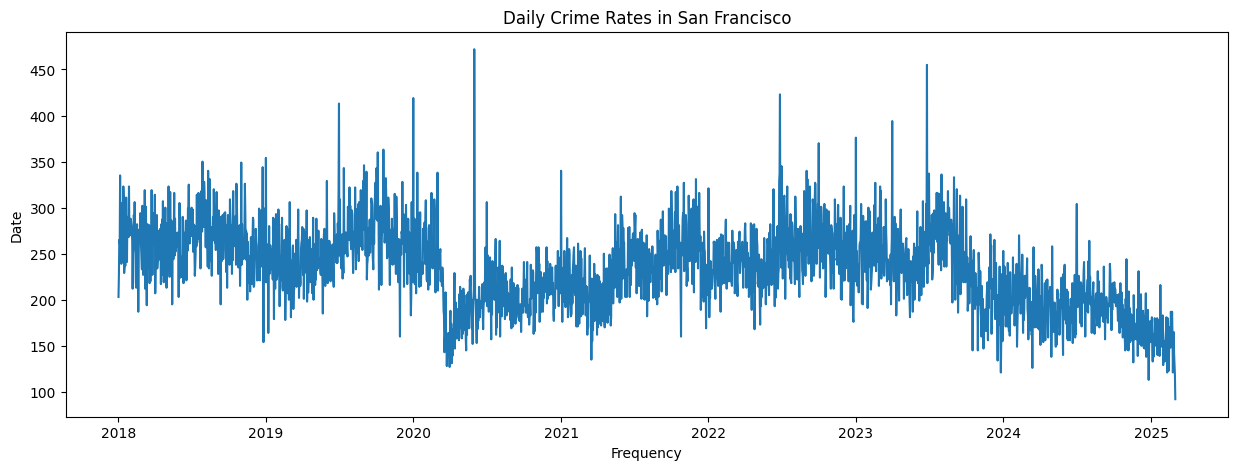

In [5]:
ts = data['datetime'].value_counts().sort_index(ascending=True)
ts = pd.DataFrame(ts)[:-1] # ignore outlier at last day of data collection (incomplete day)

print(f'Time Series Size: {len(ts)}')

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(ts) 
ax.set_title('Daily Crime Rates in San Francisco')
ax.set_xlabel('Frequency')
ax.set_ylabel('Date')

plt.show()

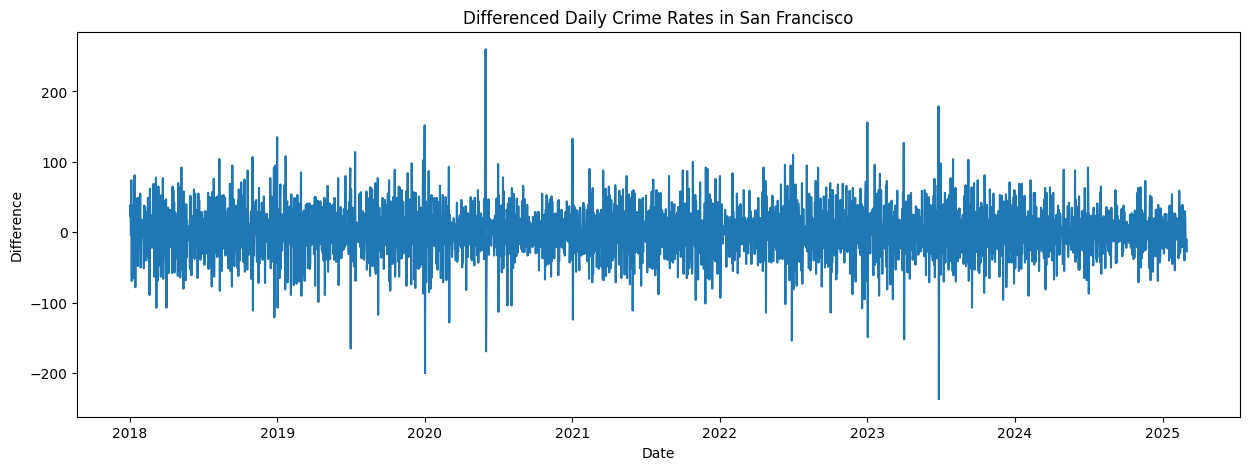

In [6]:
ts['diff1'] = ts['count'].diff(1)
#ts['diff1lag1'] = ts['diff1'].shift(1)

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(ts['diff1'])
ax.set_title('Differenced Daily Crime Rates in San Francisco')
ax.set_ylabel('Difference')
ax.set_xlabel('Date')

plt.show()

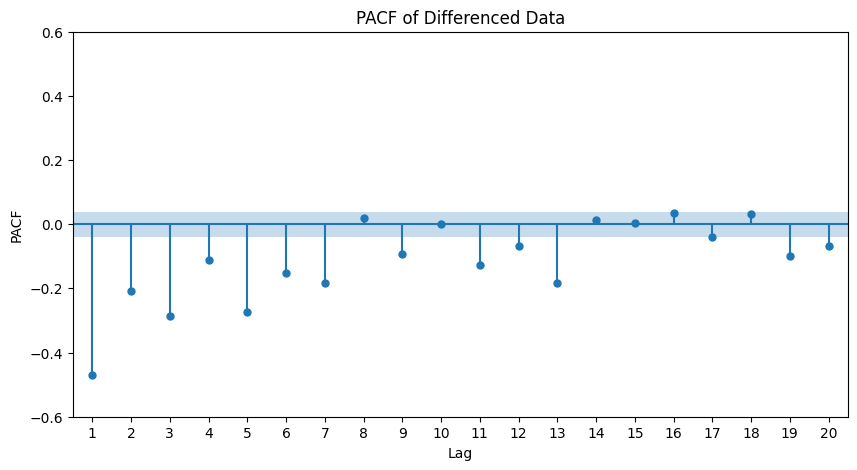

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plot_pacf(ts['diff1'].dropna(), lags=20, ax=ax)
ax.set_title('PACF of Differenced Data')
ax.set_xticks(range(0,21))
ax.set_xlim(0.5, 20.5)
ax.set_ylim(-0.6, 0.6)
ax.set_ylabel('PACF')
ax.set_xlabel('Lag')

plt.show()

In [8]:
ts['next'] = ts['count'].shift(-1)
display(ts.head())

,count,diff1,next
datetime,,,
2018-01-01,203,NaN,226.0
2018-01-02,226,23.0,265.0
2018-01-03,265,39.0,261.0
2018-01-04,261,-4.0,335.0
2018-01-05,335,74.0,266.0


In [9]:
# create lag1, lag3, lag5 features
for lag in [1, 3, 5]:
    ts[f'lag{lag}'] = ts['count'].shift(lag)

# create rolling means and stds
ma = pd.DataFrame()
mstd = pd.DataFrame()
mtrend = pd.DataFrame()
for window in [3,7,15,30]:
    rolling = ts['count'].rolling(window) # exclude current information
    ma[f'ma{window}'] = rolling.mean()
    mstd[f'mstd{window}'] = rolling.std()
    mtrend[f'mtrend{window}'] = ma[f'ma{window}'].diff()

ts = pd.concat([ts, ma, mstd, mtrend], axis=1)
ts

,count,diff1,next,lag1,lag3,lag5,ma3,ma7,ma15,ma30,mstd3,mstd7,mstd15,mstd30,mtrend3,mtrend7,mtrend15,mtrend30
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,203,NaN,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,226,23.0,265.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,265,39.0,261.0,226.0,NaN,NaN,231.333333,NaN,NaN,NaN,31.342197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,261,-4.0,335.0,265.0,203.0,NaN,250.666667,NaN,NaN,NaN,21.455380,NaN,NaN,NaN,19.333333,NaN,NaN,NaN
2018-01-05,335,74.0,266.0,261.0,226.0,NaN,287.000000,NaN,NaN,NaN,41.617304,NaN,NaN,NaN,36.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-26,165,14.0,141.0,151.0,161.0,171.0,145.666667,161.571429,160.733333,157.200000,22.479620,21.157009,19.958767,19.419862,1.333333,-3.142857,-1.000000,0.533333
2025-02-27,141,-24.0,129.0,165.0,121.0,187.0,152.333333,156.714286,158.333333,156.700000,12.055428,21.460928,20.027362,19.643635,6.666667,-4.857143,-2.400000,-0.500000
2025-02-28,129,-12.0,119.0,141.0,151.0,161.0,145.000000,150.714286,157.133333,155.800000,18.330303,22.640040,21.256484,20.284868,-7.333333,-6.000000,-1.200000,-0.900000


In [10]:
# date features
ts['year'] = ts.index.year
ts['day'] = ts.index.day
ts['month'] = ts.index.month
ts['weekend'] = ts.index.weekday >= 5
ts['holiday'] = ts.index.isin(holidays.US())
ts

,count,diff1,next,lag1,lag3,lag5,ma3,ma7,ma15,ma30,...,mstd30,mtrend3,mtrend7,mtrend15,mtrend30,year,day,month,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,203,NaN,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,1,False,False
2018-01-02,226,23.0,265.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,2,1,False,False
2018-01-03,265,39.0,261.0,226.0,NaN,NaN,231.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,3,1,False,False
2018-01-04,261,-4.0,335.0,265.0,203.0,NaN,250.666667,NaN,NaN,NaN,...,NaN,19.333333,NaN,NaN,NaN,2018,4,1,False,False
2018-01-05,335,74.0,266.0,261.0,226.0,NaN,287.000000,NaN,NaN,NaN,...,NaN,36.333333,NaN,NaN,NaN,2018,5,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-26,165,14.0,141.0,151.0,161.0,171.0,145.666667,161.571429,160.733333,157.200000,...,19.419862,1.333333,-3.142857,-1.000000,0.533333,2025,26,2,False,False
2025-02-27,141,-24.0,129.0,165.0,121.0,187.0,152.333333,156.714286,158.333333,156.700000,...,19.643635,6.666667,-4.857143,-2.400000,-0.500000,2025,27,2,False,False
2025-02-28,129,-12.0,119.0,141.0,151.0,161.0,145.000000,150.714286,157.133333,155.800000,...,20.284868,-7.333333,-6.000000,-1.200000,-0.900000,2025,28,2,False,False


## Forecasting with XGBoost

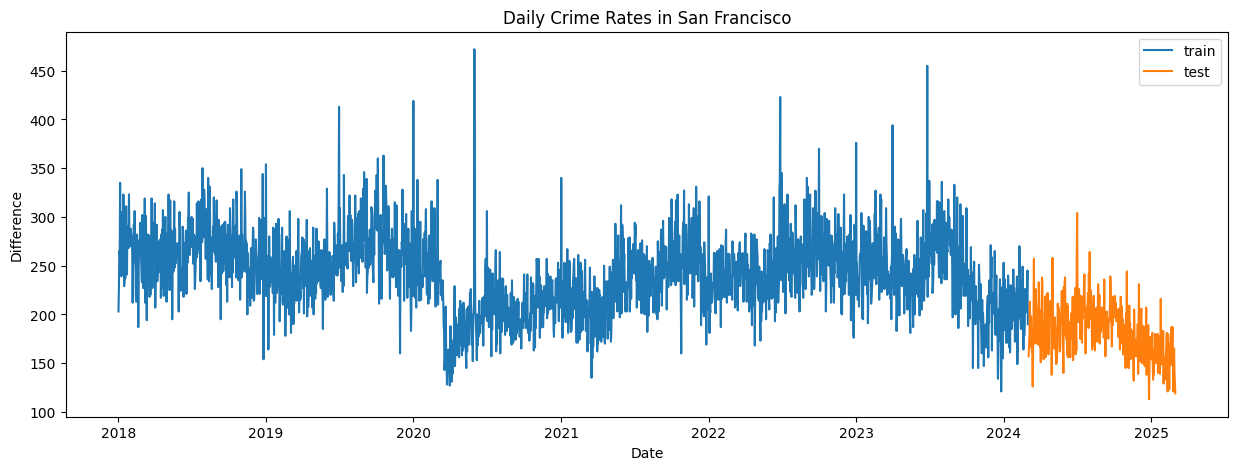

In [11]:
# simple train test split
cutoff_date = ts.index[-1] - pd.Timedelta(days=365)
train = ts[ts.index <= cutoff_date].iloc[:-1].copy()
test = ts[ts.index > cutoff_date].iloc[:-1].copy()

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(train['count'], label='train')
ax.plot(test['count'], label='test')
ax.set_title('Daily Crime Rates in San Francisco')
ax.set_ylabel('Difference')
ax.set_xlabel('Date')
ax.legend()

plt.show()

In [12]:
trainX = train.drop(labels=['next'], axis=1)
trainY = train['next']
testX = test.drop(labels=['next'], axis=1)
testY = test['next']

xgb = XGBRegressor(n_estimators=500)
xgb.fit(trainX, trainY, eval_set=[(testX, testY)], verbose=50)

[0]	validation_0-rmse:54.04671
[50]	validation_0-rmse:32.49807
[100]	validation_0-rmse:33.15579
[150]	validation_0-rmse:33.09334
[200]	validation_0-rmse:33.11191
[250]	validation_0-rmse:33.15043
[300]	validation_0-rmse:33.15558
[350]	validation_0-rmse:33.15278
[400]	validation_0-rmse:33.15544
[450]	validation_0-rmse:33.15454
[499]	validation_0-rmse:33.15451


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

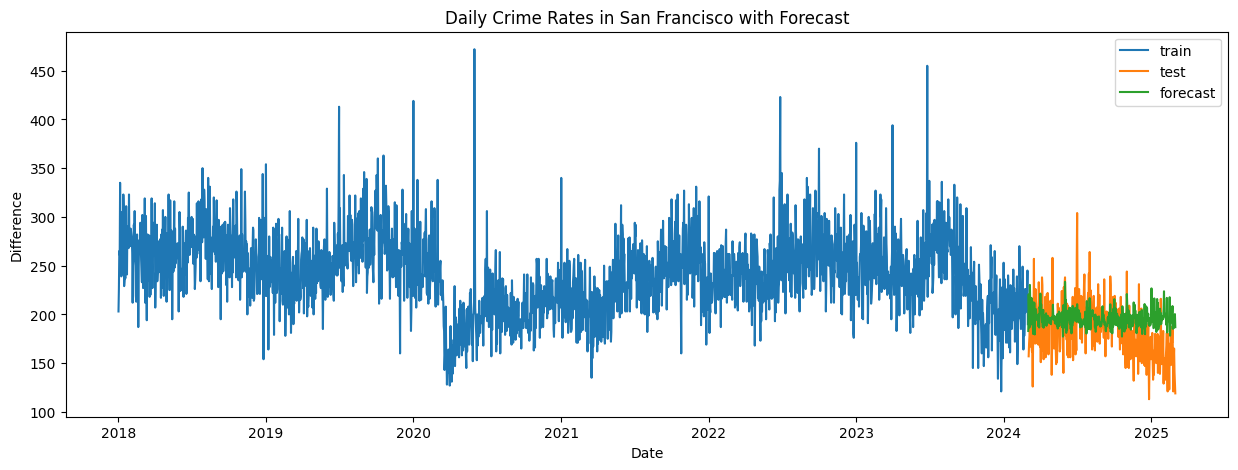

In [13]:
# predict one date ahead function
def predict_next_day(data, model):
    # predict next date
    X = data.drop(labels=['next'], axis=1).iloc[-1]
    pred = model.predict([X])[0]

    # add row to dataframe
    nextdate = data.index[-1] + pd.Timedelta(days=1)
    data.loc[nextdate] = 0.0

    #data.loc[nextdate, 'diff1lag1'] = data.iloc[-2]['diff1']
    data.loc[nextdate, 'lag1'] = data.iloc[-2]['count']
    data.loc[nextdate, 'lag3'] = data.iloc[-4]['count']
    data.loc[nextdate, 'lag5'] = data.iloc[-7]['count']

    data.loc[nextdate, 'year'] = nextdate.year
    data.loc[nextdate, 'day'] = nextdate.day
    data.loc[nextdate, 'month'] = nextdate.month
    data.loc[nextdate, 'weekend'] = (nextdate.weekday() >= 5)
    data.loc[nextdate, 'holiday'] = (nextdate in holidays.US())
    data['holiday'] = data['holiday'].astype(bool)
    data['weekend'] = data['weekend'].astype(bool)

    for window in [3,7,15,30]:
        rolling = data['count'].rolling(window)
        data.loc[nextdate, f'ma{window}'] = rolling.mean().iloc[-1]
        data.loc[nextdate, f'mstd{window}'] = rolling.std().iloc[-1]
        data.loc[nextdate, f'mtrend{window}'] = data[f'ma{window}'].diff().iloc[-1]
    
    data.loc[nextdate, 'count'] = pred
    data.loc[nextdate, 'diff1'] = pred - data.iloc[-2]['count']

futures = train.copy()
# predict next n days
n = 365
for i in range(n):
    predict_next_day(futures, xgb)

# visualize forecast
forecast_start = train.index[-1] + pd.Timedelta(days=1)

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(train['count'], label='train')
ax.plot(test['count'], label='test')
ax.plot(futures[futures.index >= forecast_start]['count'], label='forecast')
ax.set_title('Daily Crime Rates in San Francisco with Forecast')
ax.set_ylabel('Difference')
ax.set_xlabel('Date')
ax.legend()

plt.show()

## Finetuning XGB

In [29]:
def time_series_cv(data, model):
    # set up time-series kfold split
    len_test = 365 # length of test set in days
    n_folds = 3
    dates = [data.index[-1] - pd.Timedelta(days=len_test*n_folds-i) for i in range(n_folds)] # end dates for train set for each fold

    scores = []
    for date in dates:
        train = data[data.index <= date].copy()
        test = data[data.index > date].iloc[:len_test].copy()

        trainX = train.drop(labels=['next'], axis=1)
        trainY = train['next']
        testX = test.drop(labels=['next'], axis=1)
        testY = test['next']

        model.fit(trainX, trainY, eval_set=[(testX, testY)], verbose=0)
        preds = model.predict(testX)
        scores.append(root_mean_squared_error(testY, preds))
    return np.mean(scores)

def xgb_objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 10, log=True),
        'verbosity': 0
    }
    
    model = XGBRegressor(eval_metric='rmse',early_stopping_rounds=20,**params)
    kfscore = time_series_cv(ts, model)
    return kfscore

study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective, n_trials=1000, gc_after_trial=True)

best_params = study.best_params
print(f'Best params: {best_params}')
print(f'Best score: {study.best_value}')

[I 2025-05-06 15:52:27,369] A new study created in memory with name: no-name-571caa50-fa1a-4c08-998e-3f42a41d8cb6
[I 2025-05-06 15:52:28,948] Trial 0 finished with value: 30.600632438089534 and parameters: {'n_estimators': 824, 'learning_rate': 0.01064354761752883, 'max_depth': 3, 'min_child_weight': 8.34219688578177, 'gamma': 1.7538181848514256, 'subsample': 0.8925585847976398, 'colsample_bytree': 0.777019699727812, 'colsample_bylevel': 0.5970430147799517, 'colsample_bynode': 0.6939240242781426, 'reg_alpha': 0.26582597996158375, 'reg_lambda': 0.19244714124978216}. Best is trial 0 with value: 30.600632438089534.
[I 2025-05-06 15:52:39,235] Trial 1 finished with value: 31.38943664429907 and parameters: {'n_estimators': 896, 'learning_rate': 0.0030581368717830606, 'max_depth': 17, 'min_child_weight': 5.052729006621454, 'gamma': 1.6532541255877824, 'subsample': 0.6904308747148344, 'colsample_bytree': 0.7665369441988317, 'colsample_bylevel': 0.8328985686838359, 'colsample_bynode': 0.587057

Best params: {'n_estimators': 220, 'learning_rate': 0.20078622439664304, 'max_depth': 3, 'min_child_weight': 0.17896958169731508, 'gamma': 4.402682030050563, 'subsample': 0.9072126018387647, 'colsample_bytree': 0.525167853923795, 'colsample_bylevel': 0.9394448972976759, 'colsample_bynode': 0.8964140825544021, 'reg_alpha': 0.0011976168157234834, 'reg_lambda': 9.841404706379151e-05}
Best score: 29.357070185956612


In [28]:
best_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': 0.5666429335831357,
 'colsample_bynode': 0.8157067748567777,
 'colsample_bytree': 0.9220914741052032,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 3.3682129808909544,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.07411709000566628,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 0.13604507353405015,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 419,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.3030638744043382,
 'reg_lambda': 0.0012191897562906714,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.6250785005917028,
 'tree

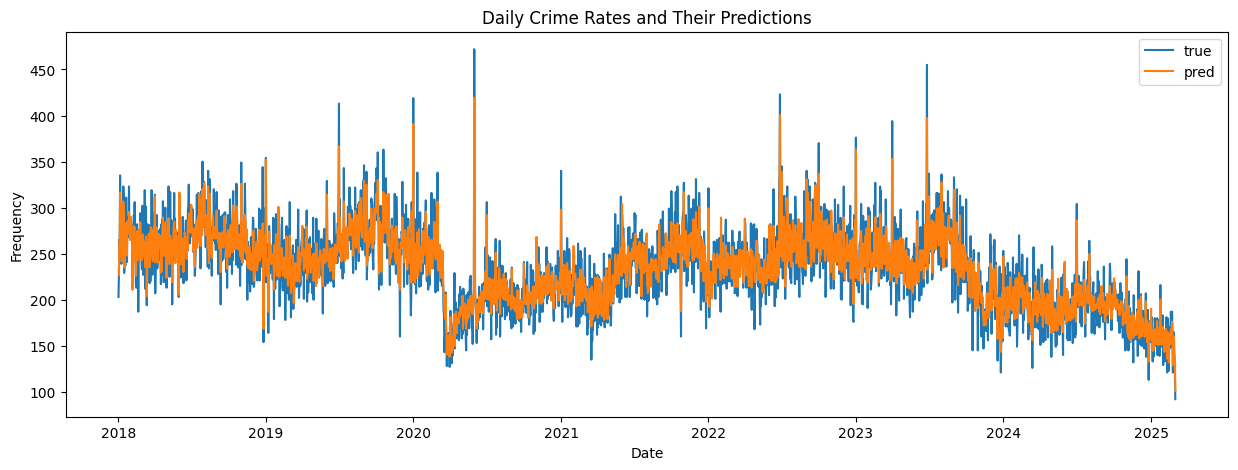

In [30]:
# visualizing fit on training data
best_model = XGBRegressor(**best_params)

X = ts.drop(labels=['next'], axis=1).iloc[:-1]
Y = ts['next'].iloc[:-1]

best_model.fit(X,Y)
preds = best_model.predict(X)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(ts.index, ts['count'], label='true')
ax.plot(ts.index[1:], preds, label='pred')
ax.set_title('Daily Crime Rates and Their Predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

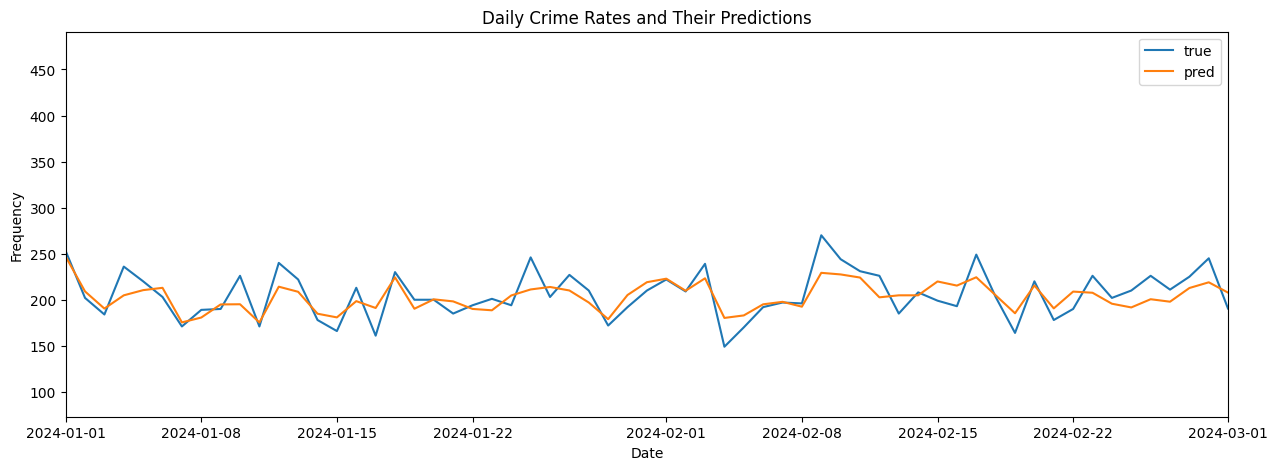

In [33]:
# zoom in on particular set of dates
start_date = "2024-01-01"
end_date = "2024-03-01"

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(ts.index, ts['count'], label='true')
ax.plot(ts.index[1:], preds, label='pred')
ax.set_title('Daily Crime Rates and Their Predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
ax.legend()

plt.show()